<a href="https://colab.research.google.com/github/DeuklyoungKo/MakeYourFirstGANWithPyTorch/blob/main/ch07_02_handwritingGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas,random, numpy
import matplotlib.pyplot as plt

## 판별기

In [19]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 신경망 레이어 정의  
    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.Sigmoid(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    #모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  
#노이즈 만들기
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

## 생성기

In [20]:
class Generator(nn.Module):
  
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1,200),
        nn.Sigmoid(),
        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter =0;
    self.progress = []


    pass

  def forward(self, inputs):
    #모델 실행
    return self.model(inputs)
  
  def train(self, D, inputs, targets):
    #신경망 출력 계산
    g_output = self.forward(inputs)

    #판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화 하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

In [21]:
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    label = self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label] = 1.0

    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass
  
  pass

## 훈련전 생성기 테스트

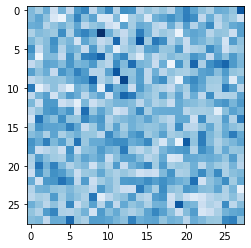

In [22]:
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')

In [23]:
from google.colab import drive
drive.mount('./mount')

mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/Deep Learning/MakeYourFirstGANWithPyTorch/mnist_data/mnist_train.csv')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


## 훈련하기

In [24]:
D = Discriminator()
G = Generator()

# 판별기와 생성기 훈련
for label, image_data_tensor, target_tensor in mnist_dataset:
  # 참에 대해 판별기 훈련
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detach() 함수를 이용
  D.train(G.forward(generate_random(1)).detach(),torch.FloatTensor([0.0]))

  # 생성기 훈련
  G.train(D, generate_random(1), torch.FloatTensor([1.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


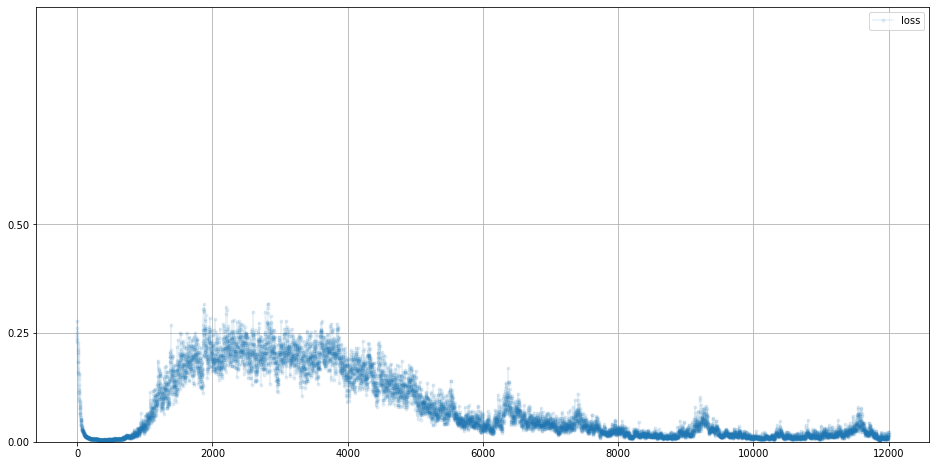

In [25]:
D.plot_progress()

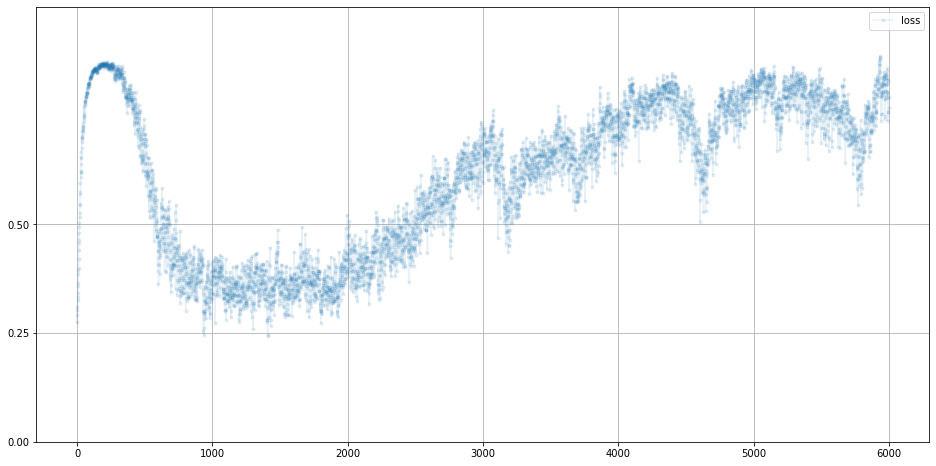

In [26]:
G.plot_progress()

## 훈련 후 생성기 테스트

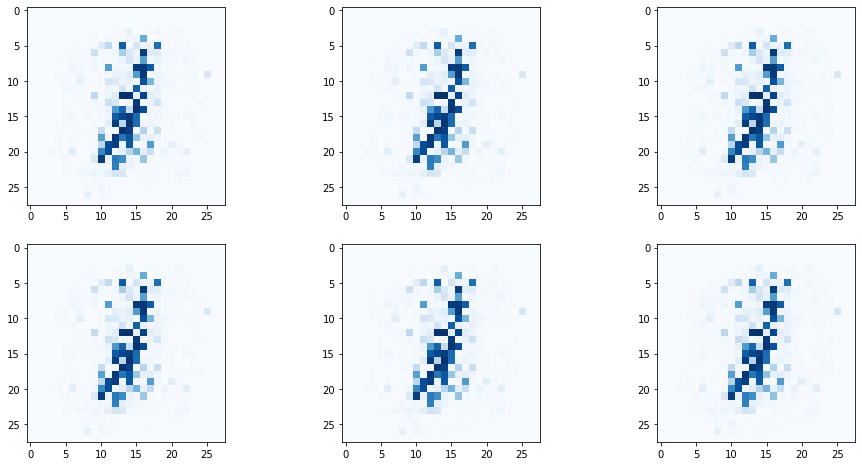

In [27]:
f, axarr = plt.subplots(2,3, figsize=(16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().reshape(28, 28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass